In [1]:
# Import neccesary libraries
import pandas as pd
import numpy as np 
import imblearn
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve, StratifiedShuffleSplit, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.cluster import KMeans, kmeans_plusplus
import xgboost as xgb

from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from collections import Counter

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv('customer_segmentation.csv')

In [3]:
df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### The dataset contains the following columns:

- InvoiceNo: Invoice number, a unique identifier for each transaction.
- StockCode: Product item code.
- Description: Product description.
- Quantity: The number of units purchased in the transaction.
- InvoiceDate: The date and time of the purchase.
- UnitPrice: Price per unit of the product.
- CustomerID: A unique identifier for each customer.
- Country: The country of origin of the customer.

## Data Cleaning and Preprocessing

In [4]:
# Check for missing values
missing_data = df.isnull().sum()

# Convert 'InvoiceDate' to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove rows with missing CustomerID
data_cleaned = df.dropna(subset=['CustomerID'])

# Convert CustomerID from float to int
data_cleaned['CustomerID'] = data_cleaned['CustomerID'].astype(int)

# Remove duplicate entries
data_cleaned = data_cleaned.drop_duplicates()

# Remove 'index' and 'Description'
data_cleaned.drop(columns=['index', 'Description'], inplace=True)

# Remove records with negative or zero quantities, and non-positive unit prices
data_cleaned = data_cleaned[(data_cleaned['Quantity'] > 0)]
data_cleaned = data_cleaned[(data_cleaned['UnitPrice'] > 0.01)]

# Summary of actions
cleaning_summary = {
    "Initial Data Shape": df.shape,
    "Data Shape after Cleaning": data_cleaned.shape,
    "Missing Data per Column": missing_data,
    "Data Types after Conversion": data_cleaned.dtypes
}

cleaning_summary

C:\Users\haoli\AppData\Local\Temp\ipykernel_27264\677397352.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['CustomerID'] = data_cleaned['CustomerID'].astype(int)


{'Initial Data Shape': (541909, 9),
 'Data Shape after Cleaning': (397880, 7),
 'Missing Data per Column': index               0
 InvoiceNo           0
 StockCode           0
 Description      1454
 Quantity            0
 InvoiceDate         0
 UnitPrice           0
 CustomerID     135080
 Country             0
 dtype: int64,
 'Data Types after Conversion': InvoiceNo              object
 StockCode              object
 Quantity                int64
 InvoiceDate    datetime64[ns]
 UnitPrice             float64
 CustomerID              int32
 Country                object
 dtype: object}

### Data Summary
- Initial Data Shape: 541,909 rows and 9 columns.
- Data Shape after Cleaning: 397,880 rows and 9 columns.
- Rows with missing CustomerID were removed, and duplicates were dropped.
- Missing Data: The CustomerID column had 135,080 missing entries, and the Description column had 1,454 missing entries.
- All missing CustomerID entries were removed.
- All records with non-positive quantity were removed.
- All records with non-positive unitprice were removed.
- Data Types Adjusted: Converted InvoiceDate to datetime format and changed CustomerID from float to integer.


## Exploratoty Data Analysis (EDA)

I will conduct an exploratory data analysis to understand the distributions of key variables, their relationships, and to identify any notable trends or patterns. This will include:

- Distribution of transactions by country.
- Analysis of quantity and unit prices.
- Trends over time based on invoice date.

In [5]:
# Distribution of transactions by country
country_distribution = data_cleaned['Country'].value_counts()

# Basic descriptive statistics for 'Quantity' and 'UnitPrice'
quantity_stats = data_cleaned['Quantity'].describe()
unit_price_stats = data_cleaned['UnitPrice'].describe()

In [6]:
country_distribution

Country
United Kingdom          354317
Germany                   9040
France                    8341
EIRE                      7236
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45


In [7]:
quantity_stats

count    397880.000000
mean         12.988358
std         179.332672
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [8]:
unit_price_stats

count    397880.000000
mean          3.116519
std          22.097986
min           0.040000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

### Exploratory Data Analysis (EDA) Results
1. Transaction Distribution by Country
The majority of transactions come from the United Kingdom, with 354,317 transactions, followed by Germany (9,040), France (8,341), EIRE (7,236), and Spain (2,484). This indicates a strong market focus in the UK, which may influence customer behavior and buying patterns.

2. Descriptive Statistics for Quantity and Unit Price
- Quantity:
The average quantity per transaction is approximately 13 items.
However, there is a high standard deviation, suggesting significant variance in the number of items per purchase.
The minimum and maximum values show extreme values (1 and 80,995)
- Unit Price:
The average unit price is about £3.12.
Similar to quantity, there's a high standard deviation and extreme values in unit prices, ranging from £0.04 to £8,142.75.

To further understand the data, I will analyze trends over time, particularly how customer purchasing behavior varies by month or season.

In [9]:
# Add a 'YearMonth' column for trend analysis
data_cleaned['YearMonth'] = data_cleaned['InvoiceDate'].dt.to_period('M')

# Monthly trend analysis
monthly_trends = data_cleaned.groupby('YearMonth').agg(Total_Quantity=('Quantity', 'sum'), Total_Sales=('UnitPrice', 'sum')).reset_index()

monthly_trends

,YearMonth,Total_Quantity,Total_Sales
0,2010-12,312265,81935.61
1,2011-01,349098,66964.99
2,2011-02,265622,63185.76
3,2011-03,348503,88563.10
4,2011-04,292221,79005.48
5,2011-05,373601,102128.28
6,2011-06,363699,85274.73
7,2011-07,369419,75919.90
8,2011-08,398121,79423.83
9,2011-09,544895,119053.06


### Monthly Trend Analysis Results

#### Total Quantity Purchased and Total Sales Over Time:
The quantity of items purchased and total sales both fluctuate throughout the year.
There is a noticeable peak in November 2011, where both total quantity (669,051 items) and total sales (£185,522.46) are highest, likely due to increased shopping activity around the holiday season.
December 2011 shows a sharp decline in both metrics, which may be attributed to the dataset only capturing part of the month's transactions.
The month-to-month variation could reflect different marketing campaigns, seasonal effects, or varying economic conditions.

## Customer Clustering 

I will proceed with the customer segmentation using clustering. To do this, I need to create a customer-level dataset that includes features like total spend, average spend per transaction, total items purchased, and frequency of purchases. These features will help us differentiate customer behaviors and preferences.

### Steps to Create Customer-Level Features:
- Total Spend: Calculate the total amount each customer has spent.
- Total Items Purchased: Sum up all items purchased by each customer.
- Average Spend Per Transaction: Compute the average spend for each customer per transaction.
- Frequency of Purchases: Count the number of transactions per customer.

In [10]:
# Create customer-level features
customer_data = data_cleaned.groupby('CustomerID').agg(
    Total_Spend=pd.NamedAgg(column='UnitPrice', aggfunc=lambda x: (x * data_cleaned.loc[x.index, 'Quantity']).sum()),
    Total_Items=pd.NamedAgg(column='Quantity', aggfunc='sum'),
    Average_Spend_Per_Transaction=pd.NamedAgg(column='InvoiceNo', aggfunc=lambda x: (data_cleaned.loc[x.index, 'UnitPrice'] * data_cleaned.loc[x.index, 'Quantity']).sum() / x.nunique()),
    Purchase_Frequency=pd.NamedAgg(column='InvoiceNo', aggfunc='nunique')
).reset_index()

customer_data.head()


,CustomerID,Total_Spend,Total_Items,Average_Spend_Per_Transaction,Purchase_Frequency
0,12346,77183.60,74215,77183.600000,1
1,12347,4310.00,2458,615.714286,7
2,12348,1797.24,2341,449.310000,4
3,12349,1757.55,631,1757.550000,1
4,12350,334.40,197,334.400000,1


After creating these features, we will standardize the data to ensure each feature contributes equally to the clustering process and then use K-Means clustering to identify customer segments.

c:\Users\haoli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\haoli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
c:\Users\haoli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\haoli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environm

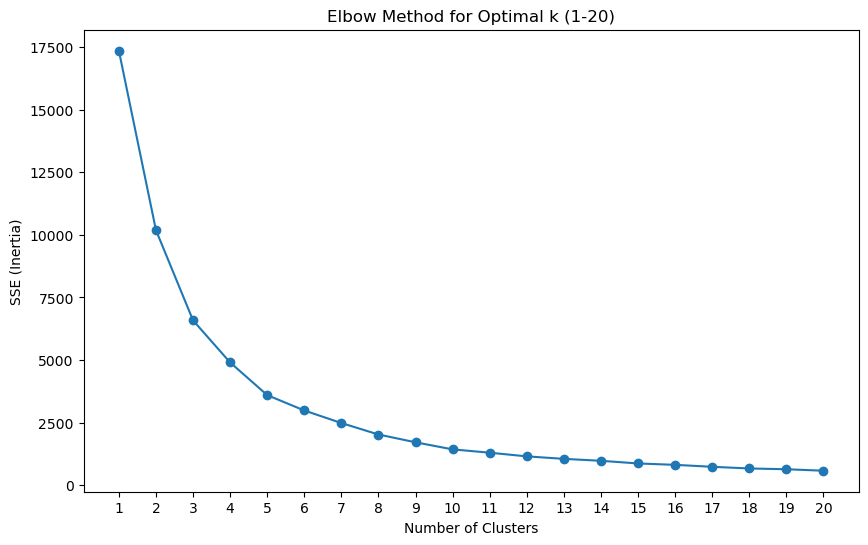

In [11]:
# Standardize the customer-level features
scaler_corrected = StandardScaler()
scaled_features_corrected = scaler_corrected.fit_transform(customer_data[['Total_Spend', 'Total_Items', 'Average_Spend_Per_Transaction', 'Purchase_Frequency']])

# Determination of the optimal number of clusters using the elbow method for k values up to 10 initially
sse_incremental = []
for k in range(1, 21):
    kmeans_incremental = KMeans(n_clusters=k, random_state=42)
    kmeans_incremental.fit(scaled_features_corrected)
    sse_incremental.append(kmeans_incremental.inertia_)

# Plot SSE for different values of k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), sse_incremental, marker='o')
plt.title('Elbow Method for Optimal k (1-20)')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.xticks(range(1, 21))
plt.show()

In [12]:
# Apply K-Means clustering with the elbow point number of clusters (5 clusters)
kmeans_final = KMeans(n_clusters=5, random_state=42)
kmeans_final.fit(scaled_features_corrected)

# Assign cluster labels to the customer data
customer_data['Cluster'] = kmeans_final.labels_

# Summarize the cluster characteristics
cluster_summary = customer_data.groupby('Cluster').agg(
    Average_Total_Spend=('Total_Spend', 'mean'),
    Average_Total_Items=('Total_Items', 'mean'),
    Average_Spend_Per_Transaction=('Average_Spend_Per_Transaction', 'mean'),
    Average_Purchase_Frequency=('Purchase_Frequency', 'mean')
).reset_index()

cluster_summary

c:\Users\haoli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\haoli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


,Cluster,Average_Total_Spend,Average_Total_Items,Average_Spend_Per_Transaction,Average_Purchase_Frequency
0,0,982.121023,586.620403,354.575709,2.825693
1,1,219559.792500,102824.250000,3277.743215,95.000000
2,2,122828.050000,77606.000000,80709.925000,1.500000
3,3,8090.220731,4527.301170,613.409960,16.383041
4,4,56081.834000,36203.950000,1318.038474,66.400000


In [14]:
customer_data.head()

,CustomerID,Total_Spend,Total_Items,Average_Spend_Per_Transaction,Purchase_Frequency,Cluster
0,12346,77183.60,74215,77183.600000,1,2
1,12347,4310.00,2458,615.714286,7,0
2,12348,1797.24,2341,449.310000,4,0
3,12349,1757.55,631,1757.550000,1,0
4,12350,334.40,197,334.400000,1,0


### Cluster Summaries
#### Cluster 0
- Average Total Spend: 982.12
- Average Total Items: 586.62
- Average Spend Per Transaction: 354.58
- Average Purchase Frequency: 2.83
- Profile: Occasional Shoppers

Customers in this cluster make relatively few transactions but spend a moderate amount per transaction. They buy a moderate number of items and visit the store occasionally.

#### Cluster 1
- Average Total Spend: 21,959.79
- Average Total Items: 10,282.25
- Average Spend Per Transaction: 3,277.74
- Average Purchase Frequency: 95.00
- Profile: Bulk Buyers / Wholesale Customers

This cluster includes high-value customers who buy in large quantities and visit frequently. They spend significantly more per transaction and are likely responsible for a substantial portion of revenue.

#### Cluster 2
- Average Total Spend: 12,282.05
- Average Total Items: 7,766.00
- Average Spend Per Transaction: 80,709.93
- Average Purchase Frequency: 1.50
- Profile: High Rollers / Large-Scale Transactions

These are likely commercial clients or special event customers who make very large purchases infrequently. Their extremely high spend per transaction suggests they purchase expensive or high-volume items less frequently.

#### Cluster 3
- Average Total Spend: 8,090.22
- Average Total Items: 4,527.30
- Average Spend Per Transaction: 613.41
- Average Purchase Frequency: 16.38
- Profile: Regular Customers

Regular customers who shop more frequently than the occasional shoppers and spend a good amount per transaction. They are consistent buyers, contributing regularly to sales.

#### Cluster 4
- Average Total Spend: 56,081.83
- Average Total Items: 3,620.95
- Average Spend Per Transaction: 1,318.08
- Average Purchase Frequency: 66.40
- Profile: Frequent Large-Spend Customers

These customers visit often and spend large amounts per transaction. They may be smaller retailers or dedicated individuals who consistently make substantial purchases.